**All the models in this notebook are run on CIFAR10 Dataset:**

This notebook contains all the performer models (reLU, softmax as well as the positive random features variation) and the Transformer model on CIFAR10 datasets

Performer - ReLU (from scratch)

In [ ]:
import tensorflow as tf

_CHR_IDX = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"]


@tf.keras.utils.register_keras_serializable(package="Text")
class DenseEinsum(tf.keras.layers.Layer):
  """A densely connected layer that uses tf.einsum as the backing computation.

  This layer can perform einsum calculations of arbitrary dimensionality.

  Arguments:
    output_shape: Positive integer or tuple, dimensionality of the output space.
    num_summed_dimensions: The number of dimensions to sum over. Standard 2D
      matmul should use 1, 3D matmul should use 2, and so forth.
    activation: Activation function to use. If you don't specify anything, no
      activation is applied
      (ie. "linear" activation: `a(x) = x`).
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    kernel_regularizer: Regularizer function applied to the `kernel` weights
      matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    activity_regularizer: Regularizer function applied to the output of the
      layer (its "activation")..
    kernel_constraint: Constraint function applied to the `kernel` weights
      matrix.
    bias_constraint: Constraint function applied to the bias vector.
  Input shape:
    N-D tensor with shape: `(batch_size, ..., input_dim)`. The most common
      situation would be a 2D input with shape `(batch_size, input_dim)`.
  Output shape:
    N-D tensor with shape: `(batch_size, ..., units)`. For instance, for a 2D
      input with shape `(batch_size, input_dim)`, the output would have shape
      `(batch_size, units)`.
  """

  def __init__(self,
               output_shape,
               num_summed_dimensions=1,
               activation=None,
               use_bias=True,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(DenseEinsum, self).__init__(**kwargs)
    self._output_shape = output_shape if isinstance(
        output_shape, (list, tuple)) else (output_shape,)
    self._activation = tf.keras.activations.get(activation)
    self._use_bias = use_bias
    self._kernel_initializer = tf.keras.initializers.get(kernel_initializer)
    self._bias_initializer = tf.keras.initializers.get(bias_initializer)
    self._kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
    self._bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
    self._kernel_constraint = tf.keras.constraints.get(kernel_constraint)
    self._bias_constraint = tf.keras.constraints.get(bias_constraint)
    self._num_summed_dimensions = num_summed_dimensions
    self._einsum_string = None

  def _build_einsum_string(self, free_input_dims, bound_dims, output_dims):
    input_str = ""
    kernel_str = ""
    output_str = ""
    letter_offset = 0
    for i in range(free_input_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      output_str += char

    letter_offset += free_input_dims
    for i in range(bound_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
      char = _CHR_IDX[i + letter_offset]
      kernel_str += char
      output_str += char

    return input_str + "," + kernel_str + "->" + output_str

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    input_rank = input_shape.rank
    free_input_dims = input_rank - self._num_summed_dimensions
    output_dims = len(self._output_shape)

    self._einsum_string = self._build_einsum_string(free_input_dims,
                                                    self._num_summed_dimensions,
                                                    output_dims)

    # This is only saved for testing purposes.
    self._kernel_shape = (
        input_shape[free_input_dims:].concatenate(self._output_shape))

    self._kernel = self.add_weight(
        "kernel",
        shape=self._kernel_shape,
        initializer=self._kernel_initializer,
        regularizer=self._kernel_regularizer,
        constraint=self._kernel_constraint,
        dtype=self.dtype,
        trainable=True)
    if self._use_bias:
      self._bias = self.add_weight(
          "bias",
          shape=self._output_shape,
          initializer=self._bias_initializer,
          regularizer=self._bias_regularizer,
          constraint=self._bias_constraint,
          dtype=self.dtype,
          trainable=True)
    else:
      self._bias = None
    super(DenseEinsum, self).build(input_shape)

  def get_config(self):
    config = {
        "output_shape":
            self._output_shape,
        "num_summed_dimensions":
            self._num_summed_dimensions,
        "activation":
            tf.keras.activations.serialize(self._activation),
        "use_bias":
            self._use_bias,
        "kernel_initializer":
            tf.keras.initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            tf.keras.initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            tf.keras.regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            tf.keras.regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            tf.keras.regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            tf.keras.constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            tf.keras.constraints.serialize(self._bias_constraint)
    }
    base_config = super(DenseEinsum, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def call(self, inputs):
    ret = tf.einsum(self._einsum_string, inputs, self._kernel)
    if self._use_bias:
      ret += self._bias
    if self._activation is not None:
      ret = self._activation(ret)
    return ret

In [ ]:
! pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

In [ ]:
class Config:
    # Origin image size
    input_size = 32
    # Input shape of image
    input_shape = [input_size, input_size, 3]
    # Learning rate of the Model
    learning_rate = 0.001
    # Weight decay rate of the Model
    weight_decay = 0.0001
    # Batch size of the Model
    batch_size = 256
    num_classes = 10
    num_epochs = 60
    image_size = 32
    patch_size = 8
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]


In [ ]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Display some information about the dataset
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

170498071/170498071 [==============================] - 2s 0us/step
Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [ ]:
train = np.array(train_images).reshape((-1, Config.input_size, Config.input_size, 3))
test = np.array(test_images).reshape((-1, Config.input_size, Config.input_size, 3))


In [ ]:
train.shape

(50000, 32, 32, 3)

In [ ]:
test.shape

(10000, 32, 32, 3)

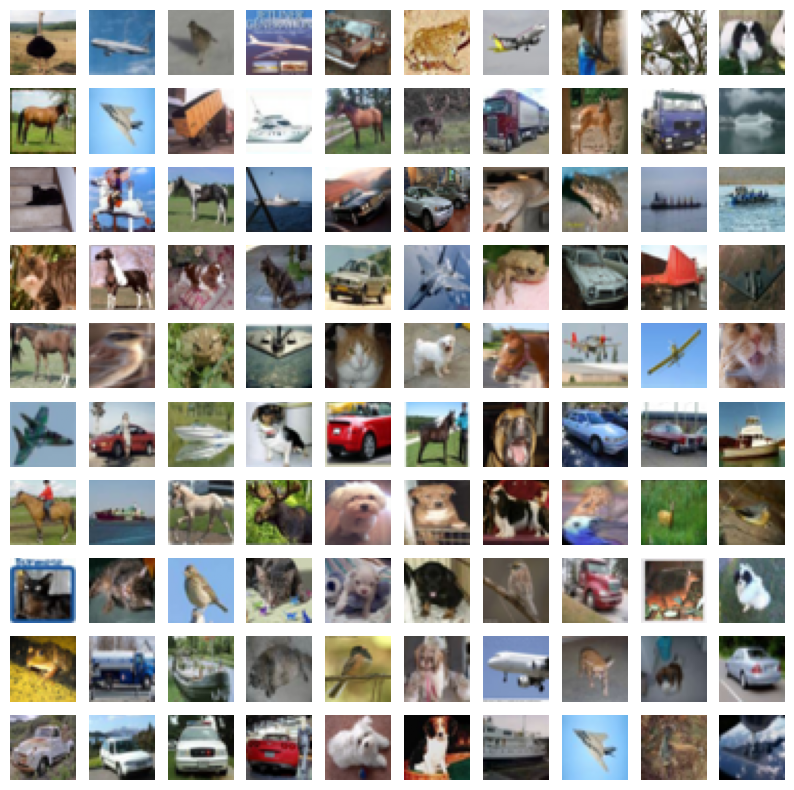

In [ ]:
indices = np.random.choice(train.shape[0], 100)
sample_images(train[indices].squeeze(), 10, 10)


In [ ]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(256, 32, 32, 3)
Image size: 32 X 32
Patch size: 6 X 6
Patches per image: 25
Elements per patch: 108


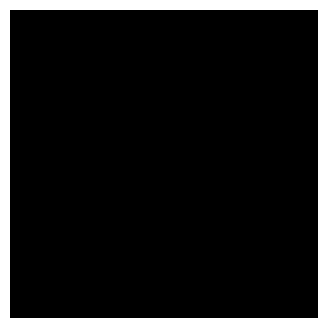

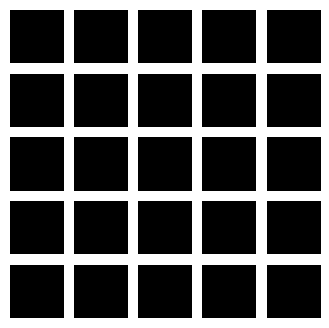

In [ ]:
plt.figure(figsize=(4, 4))
start_index = np.random.choice(train.shape[0] // 2)
image = train[start_index: start_index + Config.batch_size]
plt.imshow(np.squeeze(image[0]).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor(image), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [ ]:
import math
import numpy as np
import tensorflow as tf

In [ ]:
BIG_CONSTANT = 1e8


def create_projection_matrix(m, d, seed=0 , scaling=0, struct_mode=False):
  r"""Constructs the matrix of random projections.

  Constructs a matrix of random orthogonal projections. Each projection vector
  has direction chosen uniformly at random and either deterministic length
  \sqrt{d} or length taken from the \chi(d) distribution (in the latter case
  marginal distributions of the projections are d-dimensional Gaussian vectors
  with associated identity covariance matrix).

  Args:
    m: number of random projections.
    d: dimensionality of each random projection.
    seed: random seed used to construct projections.
    scaling: 1 if all the random projections need to be renormalized to have
      length \sqrt{d}, 0 if the lengths of random projections should follow
      \chi(d) distribution.
    struct_mode: if True then products of Givens rotations will be used to
      construct random orthogonal matrix. This bypasses Gram-Schmidt
      orthogonalization.

  Returns:
    The matrix of random projections of the shape [m, d].
  """
  nb_full_blocks = int(m / d)
  block_list = []
  current_seed = seed
  for _ in range(nb_full_blocks):
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q)
    current_seed += 1
  remaining_rows = m - nb_full_blocks * d
  if remaining_rows > 0:
    if struct_mode:
      q = create_products_of_givens_rotations(d, seed)
    else:
      unstructured_block = tf.random.normal((d, d), seed=current_seed)
      q, _ = tf.linalg.qr(unstructured_block)
      q = tf.transpose(q)
    block_list.append(q[0:remaining_rows])
  final_matrix = tf.experimental.numpy.vstack(block_list)
  current_seed += 1

  if scaling == 0:
    multiplier = tf.norm(tf.random.normal((m, d), seed=current_seed), axis=1)
  elif scaling == 1:
    multiplier = tf.math.sqrt(float(d)) * tf.ones((m))
  else:
    raise ValueError("Scaling must be one of {0, 1}. Was %s" % scaling)

  return tf.linalg.matmul(tf.linalg.diag(multiplier), final_matrix)


def create_products_of_givens_rotations(dim, seed):
  r"""Constructs a 2D-tensor which is a product of Givens random rotations.

  Constructs a 2D-tensor of the form G_1 * ... * G_k, where G_i is a Givens
  random rotation. The resulting tensor mimics a matrix taken uniformly at
  random form the orthogonal group.

  Args:
    dim: number of rows/columns of the resulting 2D-tensor.
    seed: random seed.

  Returns:
    The product of Givens random rotations.
  """
  nb_givens_rotations = dim * int(math.ceil(math.log(float(dim))))
  q = np.eye(dim, dim)
  np.random.seed(seed)
  for _ in range(nb_givens_rotations):
    random_angle = math.pi * np.random.uniform()
    random_indices = np.random.choice(dim, 2)
    index_i = min(random_indices[0], random_indices[1])
    index_j = max(random_indices[0], random_indices[1])
    slice_i = q[index_i]
    slice_j = q[index_j]
    new_slice_i = math.cos(random_angle) * slice_i + math.sin(
        random_angle) * slice_j
    new_slice_j = -math.sin(random_angle) * slice_i + math.cos(
        random_angle) * slice_j
    q[index_i] = new_slice_i
    q[index_j] = new_slice_j
  return tf.cast(tf.constant(q), dtype=tf.float32)


def relu_kernel_transformation(data,
                               is_query,
                               projection_matrix=None,
                               numerical_stabilizer=0.001):
  """Computes features for the ReLU-kernel.

  Computes random features for the ReLU kernel from
  https://arxiv.org/pdf/2009.14794.pdf.

  Args:
    data: input data tensor of the shape [B, L, H, D], where: B - batch
      dimension, L - attention dimensions, H - heads, D - features.
    is_query: indicates whether input data is a query oor key tensor.
    projection_matrix: random Gaussian matrix of shape [M, D], where M stands
      for the number of random features and each D x D sub-block has pairwise
      orthogonal rows.
    numerical_stabilizer: small positive constant for numerical stability.

  Returns:
    Corresponding kernel feature map.
  """
  del is_query
  if projection_matrix is None:
    return tf.nn.relu(data) + numerical_stabilizer
  else:
    ratio = 1.0 / tf.math.sqrt(
        tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
    data_dash = ratio * tf.einsum("blhd,md->blhm", data, projection_matrix)
    return tf.nn.relu(data_dash) + numerical_stabilizer


def softmax_kernel_transformation(data,
                                  is_query,
                                  projection_matrix=None,
                                  numerical_stabilizer=0.000001):
  """Computes random features for the softmax kernel using FAVOR+ mechanism.

  Computes random features for the softmax kernel using FAVOR+ mechanism from
  https://arxiv.org/pdf/2009.14794.pdf.

  Args:
    data: input data tensor of the shape [B, L, H, D], where: B - batch
      dimension, L - attention dimensions, H - heads, D - features.
    is_query: indicates whether input data is a query oor key tensor.
    projection_matrix: random Gaussian matrix of shape [M, D], where M stands
      for the number of random features and each D x D sub-block has pairwise
      orthogonal rows.
    numerical_stabilizer: small positive constant for numerical stability.

  Returns:
    Corresponding kernel feature map.
  """
  data_normalizer = 1.0 / (
      tf.math.sqrt(tf.math.sqrt(tf.dtypes.cast(data.shape[-1], tf.float32))))
  data = data_normalizer * data
  ratio = 1.0 / tf.math.sqrt(
      tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
  data_dash = tf.einsum("blhd,md->blhm", data, projection_matrix)
  diag_data = tf.math.square(data)
  diag_data = tf.math.reduce_sum(
      diag_data, axis=tf.keras.backend.ndim(data) - 1)
  diag_data = diag_data / 2.0
  diag_data = tf.expand_dims(diag_data, axis=tf.keras.backend.ndim(data) - 1)
  last_dims_t = (len(data_dash.shape) - 1,)
  attention_dims_t = (len(data_dash.shape) - 3,)
  if is_query:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t, keepdims=True)) + numerical_stabilizer)
  else:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t + attention_dims_t, keepdims=True)) +
        numerical_stabilizer)

  return data_dash


def noncausal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR noncausal attention AV.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].

  Returns:
    Not-normalized FAVOR noncausal attention AV.
  """
  kvs = tf.einsum("lbhm,lbhd->bhmd", ks, vs)
  return tf.einsum("lbhm,bhmd->lbhd", qs, kvs)


def noncausal_denominator(qs, ks):
  """Computes FAVOR normalizer in noncausal attention.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].

  Returns:
    FAVOR normalizer in noncausal attention.
  """
  all_ones = tf.ones([ks.shape[0]])
  ks_sum = tf.einsum("lbhm,l->bhm", ks, all_ones)
  return tf.einsum("lbhm,bhm->lbh", qs, ks_sum)


@tf.custom_gradient
def causal_numerator(qs, ks, vs):
  """Computes not-normalized FAVOR causal attention A_{masked}V.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].
    vs: value tensor of the shape [L,B,H,D].

  Returns:
    Not-normalized FAVOR causal attention A_{masked}V.
  """

  result = []
  sums = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0]))

  for index in range(qs.shape[0]):
    sums = sums + tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])
    result.append(tf.einsum("ijkl,ijk->ijl", sums, qs[index])[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    grads = tf.zeros_like(tf.einsum("ijk,ijl->ijkl", ks[0], vs[0]))

    gr_sums = sums

    q_grads = []
    k_grads = []
    v_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(
          tf.einsum("ijkl,ijl->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      grads = grads + tf.einsum("ijk,ijl->ijkl", qs[index], res_grad[index])
      k_grads.append(tf.einsum("ijkl,ijl->ijk", grads, vs[index])[None, Ellipsis])
      v_grads.append(tf.einsum("ijkl,ijk->ijl", grads, ks[index])[None, Ellipsis])
      gr_sums = gr_sums - tf.einsum("ijk,ijl->ijkl", ks[index], vs[index])

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)
    v_grads = tf.concat(v_grads[::-1], axis=0)

    return q_grads, k_grads, v_grads

  return result, grad


@tf.custom_gradient
def causal_denominator(qs, ks):
  """Computes FAVOR normalizer in causal attention.

  Args:
    qs: query_prime tensor of the shape [L,B,H,M].
    ks: key_prime tensor of the shape [L,B,H,M].

  Returns:
    FAVOR normalizer in causal attention.
  """

  result = []
  sums = tf.zeros_like(ks[0])

  for index in range(qs.shape[0]):
    sums = sums + ks[index]
    result.append(tf.reduce_sum(qs[index] * sums, axis=2)[None, Ellipsis])

  result = tf.concat(result, axis=0)

  def grad(res_grad):

    k_grad = tf.zeros_like(ks[0])

    gr_sums = sums

    q_grads = []
    k_grads = []

    for index in range(qs.shape[0] - 1, -1, -1):

      q_grads.append(
          tf.einsum("ijk,ij->ijk", gr_sums, res_grad[index])[None, Ellipsis])
      k_grad = k_grad + tf.einsum("ijk,ij->ijk", qs[index], res_grad[index])
      k_grads.append(k_grad[None, Ellipsis])
      gr_sums = gr_sums - ks[index]

    q_grads = tf.concat(q_grads[::-1], axis=0)
    k_grads = tf.concat(k_grads[::-1], axis=0)

    return q_grads, k_grads

  return result, grad


def favor_attention(query,
                    key,
                    value,
                    kernel_transformation,
                    causal,
                    projection_matrix=None):
  """Computes FAVOR normalized attention.

  Args:
    query: query tensor.
    key: key tensor.
    value: value tensor.
    kernel_transformation: transformation used to get finite kernel features.
    causal: whether attention is causal or not.
    projection_matrix: projection matrix to be used.

  Returns:
    FAVOR normalized attention.
  """
  query_prime = kernel_transformation(query, True,
                                      projection_matrix)  # [B,L,H,M]
  key_prime = kernel_transformation(key, False, projection_matrix)  # [B,L,H,M]
  query_prime = tf.transpose(query_prime, [1, 0, 2, 3])  # [L,B,H,M]
  key_prime = tf.transpose(key_prime, [1, 0, 2, 3])  # [L,B,H,M]
  value = tf.transpose(value, [1, 0, 2, 3])  # [L,B,H,D]

  if causal:
    av_attention = causal_numerator(query_prime, key_prime, value)
    attention_normalizer = causal_denominator(query_prime, key_prime)
  else:
    av_attention = noncausal_numerator(query_prime, key_prime, value)
    attention_normalizer = noncausal_denominator(query_prime, key_prime)
  # TODO(kchoro): Add more comments.
  av_attention = tf.transpose(av_attention, [1, 0, 2, 3])
  attention_normalizer = tf.transpose(attention_normalizer, [1, 0, 2])
  attention_normalizer = tf.expand_dims(attention_normalizer,
                                        len(attention_normalizer.shape))
  return av_attention / attention_normalizer


class Attention(tf.keras.layers.Layer):
  """Multi-headed attention layer."""

  def __init__(self,
               hidden_size,
               num_heads,
               attention_dropout,
               kernel_transformation=relu_kernel_transformation,
               numerical_stabilizer=0.001,
               causal=False,
               projection_matrix_type=None,
               nb_random_features=0):
    """Initialize Attention.

    Args:
      hidden_size: int, output dim of hidden layer.
      num_heads: int, number of heads to repeat the same attention structure.
      attention_dropout: float, dropout rate inside attention for training.
      kernel_transformation: transformation used to produce kernel features for
        attention.
      numerical_stabilizer: used to bound away from zero kernel values.
      causal: whether attention is causal or not.
      projection_matrix_type: None if Identity should be used, otherwise random
        projection matrix will be applied.
      nb_random_features: number of random features to be used (relevant only if
        projection_matrix is not None).
    """
    if hidden_size % num_heads:
      raise ValueError(
          "Hidden size ({}) must be divisible by the number of heads ({})."
          .format(hidden_size, num_heads))

    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.attention_dropout = attention_dropout
    self.kernel_transformation = kernel_transformation
    self.numerical_stabilizer = numerical_stabilizer
    self.causal = causal
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features

  def build(self, input_shape):
    """Builds the layer."""
    # Layers for linearly projecting the queries, keys, and values.
    size_per_head = self.hidden_size // self.num_heads

    def _glorot_initializer(fan_in, fan_out):
      limit = math.sqrt(6.0 / (fan_in + fan_out))
      return tf.keras.initializers.RandomUniform(minval=-limit, maxval=limit)

    attention_initializer = _glorot_initializer(input_shape.as_list()[-1],
                                                self.hidden_size)
    self.query_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="query")
    self.key_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="key")
    self.value_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="value")

    output_initializer = _glorot_initializer(self.hidden_size, self.hidden_size)
    self.output_dense_layer = DenseEinsum(
        output_shape=self.hidden_size,
        num_summed_dimensions=2,
        kernel_initializer=output_initializer,
        use_bias=False,
        name="output_transform")
    super(Attention, self).build(input_shape)

  def get_config(self):
    return {
        "hidden_size": self.hidden_size,
        "num_heads": self.num_heads,
        "attention_dropout": self.attention_dropout,
    }

  def call(self,
           query_input,
           source_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):
    """Apply attention mechanism to query_input and source_input.

    Args:
      query_input: A tensor with shape [batch_size, length_query, hidden_size].
      source_input: A tensor with shape [batch_size, length_source,
        hidden_size].
      bias: A tensor with shape [batch_size, 1, length_query, length_source],
        the attention bias that will be added to the result of the dot product.
      training: A bool, whether in training mode or not.
      cache: (Used during prediction) A dictionary with tensors containing
        results of previous attentions. The dictionary must have the items:
            {"k": tensor with shape [batch_size, i, heads, dim_per_head],
             "v": tensor with shape [batch_size, i, heads, dim_per_head]} where
               i is the current decoded length for non-padded decode, or max
               sequence length for padded decode.
      decode_loop_step: An integer, step number of the decoding loop. Used only
        for autoregressive inference on TPU.

    Returns:
      Attention layer output with shape [batch_size, length_query, hidden_size]
    """
    # Linearly project the query, key and value using different learned
    # projections. Splitting heads is automatically done during the linear
    # projections --> [batch_size, length, num_heads, dim_per_head].
    query = self.query_dense_layer(query_input)
    key = self.key_dense_layer(source_input)
    value = self.value_dense_layer(source_input)

    if self.projection_matrix_type is None:
      projection_matrix = None
      m = 0
    else:
      dim = query.shape[-1]
      seed = tf.math.ceil(tf.math.abs(tf.math.reduce_sum(query) * BIG_CONSTANT))
      seed = tf.dtypes.cast(seed, tf.int32)
      projection_matrix = create_projection_matrix(
          self.nb_random_features, dim)#, seed=seed)
      m = 1

    if cache is not None:
      # Combine cached keys and values with new keys and values.
      if decode_loop_step is not None:
        cache_k_shape = cache["k"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_k_shape[1], dtype=key.dtype),
            [1, cache_k_shape[1], 1, 1])
        key = cache["k"] + key * indices
        cache_v_shape = cache["v"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_v_shape[1], dtype=value.dtype),
            [1, cache_v_shape[1], 1, 1])
        value = cache["v"] + value * indices
      else:
        key = tf.concat([tf.cast(cache["k"], key.dtype), key], axis=1)
        value = tf.concat([tf.cast(cache["v"], value.dtype), value], axis=1)

      # Update cache
      cache["k"] = key
      cache["v"] = value

    attention_output = favor_attention(query, key, value,
                                       self.kernel_transformation, self.causal,
                                       projection_matrix)
    attention_output = self.output_dense_layer(attention_output)
    return attention_output


class SelfAttention(Attention):
  """Multiheaded self-attention layer."""

  def call(self,
           query_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):
    return super(SelfAttention, self).call(query_input, query_input, bias,
                                           training, cache, decode_loop_step)

In [ ]:
class MHFA(Attention):
  # def __init__():

  def call(
      self,
      query,
      value,
      key=None,
      attention_mask= None,
      return_attention_scores = None,
      training= None,
      causal= False,
      kernel_transformation=softmax_kernel_transformation,
      projection_matrix_type=True,
      nb_random_features=128

  ):


    if key is None:
      key= value

    super(Attention, self).__init__()
    self.kernel_transformation = kernel_transformation
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features
    self.casual = causal
    super(Attention, self).build(query.shape)
    attention_output=  super(MHFA, self).call(query, key, None, training)

    return attention_output

### Transformer

In [ ]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    # for i in range(Config.transformer_layers):
    # Layer Normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    # Multi-Head Attention Layer
    attention_output = layers.MultiHeadAttention(num_heads=8,key_dim=Config.projection_dim,dropout=0.1)(x1,x1)

    # attention_output.name = attention_output.name+str(i)

    # Skip Connnection 1
    x2 = attention_output + encoder_patches

    # Layer Normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

    # MLP
    x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

    # Skip Connnection 2
    encoder_patches = x3 + x2

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    # i=0
    # for layer in model.layers:
    #   layer.name = layer.name +str(i)
    #   i = i+1
    return model

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 25, 64)               8576      ['patches[0][0]']             
 r)                                                                                           

In [ ]:
import os
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "Transformer.pkl"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/60
196/196 [==============================] - 16s 24ms/step - loss: 2.1430 - accuracy: 0.2390 - val_loss: 1.6840 - val_accuracy: 0.3749
Epoch 2/60
196/196 [==============================] - 4s 20ms/step - loss: 1.7308 - accuracy: 0.3691 - val_loss: 1.5463 - val_accuracy: 0.4442
Epoch 3/60
196/196 [==============================] - 5s 23ms/step - loss: 1.5920 - accuracy: 0.4239 - val_loss: 1.3991 - val_accuracy: 0.4957
Epoch 4/60
196/196 [==============================] - 4s 20ms/step - loss: 1.5187 - accuracy: 0.4498 - val_loss: 1.3562 - val_accuracy: 0.5001
Epoch 5/60
196/196 [==============================] - 4s 20ms/step - loss: 1.4588 - accuracy: 0.4762 - val_loss: 1.2999 - val_accuracy: 0.5335
Epoch 6/60
196/196 [==============================] - 5s 24ms/step - loss: 1.4195 - accuracy: 0.4872 - val_loss: 1.2495 - val_accuracy: 0.5494
Epoch 7/60
196/196 [==============================] - 4s 21ms/step - loss: 1.3779 - accuracy: 0.5060 - val_loss: 1.2249 - val_accuracy: 0.557

In [ ]:
def create_vision_transformer(kernel=relu_kernel_transformation,random_features=128,casual=False):
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    # for i in range(Config.transformer_layers):
    # Layer Normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    # Multi-Head Attention Layer
    attention_output = MHFA(kernel_transformation=kernel, nb_random_features=random_features,
                            hidden_size=64, attention_dropout=0.1, num_heads=8,
                            projection_matrix_type=True, causal=casual)(x1,x1)
    # attention_output.name = attention_output.name+str(i)

    # Skip Connnection 1
    x2 = attention_output + encoder_patches

    # Layer Normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

    # MLP
    x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

    # Skip Connnection 2
    encoder_patches = x3 + x2

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    # i=0
    # for layer in model.layers:
    #   layer.name = layer.name +str(i)
    #   i = i+1
    return model

### random_feature:16-scratch

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer(casual=False,random_features=16)
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 25, 64)               8576      ['patches[0][0]']             
 r)                                                                                           

In [ ]:
import os
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "linformer.pkl"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/35
196/196 [==============================] - 16s 50ms/step - loss: 2.1101 - accuracy: 0.2475 - val_loss: 1.7148 - val_accuracy: 0.3783
Epoch 2/35
196/196 [==============================] - 5s 24ms/step - loss: 1.7768 - accuracy: 0.3516 - val_loss: 1.5439 - val_accuracy: 0.4324
Epoch 3/35
196/196 [==============================] - 4s 22ms/step - loss: 1.6512 - accuracy: 0.4015 - val_loss: 1.5255 - val_accuracy: 0.4538
Epoch 4/35
196/196 [==============================] - 5s 25ms/step - loss: 1.5650 - accuracy: 0.4361 - val_loss: 1.4544 - val_accuracy: 0.4800
Epoch 5/35
196/196 [==============================] - 4s 20ms/step - loss: 1.5110 - accuracy: 0.4564 - val_loss: 1.3825 - val_accuracy: 0.5050
Epoch 6/35
196/196 [==============================] - 4s 23ms/step - loss: 1.4608 - accuracy: 0.4759 - val_loss: 1.3074 - val_accuracy: 0.5252
Epoch 7/35
196/196 [==============================] - 5s 25ms/step - loss: 1.4214 - accuracy: 0.4916 - val_loss: 1.2740 - val_accuracy: 0.544

In [ ]:
checkpoint_path = "linformer.pkl"
vit_classifier.save_weights(checkpoint_path)

### random_feature:16-checkpoint

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer(casual=False,random_features=16)
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[1][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 25, 64)               8576      ['patches[0][0]']             
 r)                                                                                           

In [ ]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [ ]:
vit_classifier.load_weights(checkpoint_path)
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/35
196/196 [==============================] - 9s 26ms/step - loss: 0.8733 - accuracy: 0.6879 - val_loss: 0.9225 - val_accuracy: 0.6778
Epoch 2/35
196/196 [==============================] - 4s 21ms/step - loss: 0.8690 - accuracy: 0.6929 - val_loss: 0.9538 - val_accuracy: 0.6629
Epoch 3/35
196/196 [==============================] - 5s 25ms/step - loss: 0.8495 - accuracy: 0.6983 - val_loss: 0.8854 - val_accuracy: 0.6875
Epoch 4/35
196/196 [==============================] - 4s 21ms/step - loss: 0.8437 - accuracy: 0.7009 - val_loss: 0.9121 - val_accuracy: 0.6851
Epoch 5/35
196/196 [==============================] - 4s 20ms/step - loss: 0.8369 - accuracy: 0.7034 - val_loss: 0.8878 - val_accuracy: 0.6904
Epoch 6/35
196/196 [==============================] - 5s 26ms/step - loss: 0.8261 - accuracy: 0.7068 - val_loss: 0.8957 - val_accuracy: 0.6919
Epoch 7/35
196/196 [==============================] - 4s 22ms/step - loss: 0.8167 - accuracy: 0.7106 - val_loss: 0.9197 - val_accuracy: 0.6775

### random_feature:128

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer(casual=False)
vit_classifier.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 25, 64)               8576      ['patches[0][0]']             
 r)                                                                                           

In [ ]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))


Epoch 1/60
196/196 [==============================] - 28s 31ms/step - loss: 2.1228 - accuracy: 0.2420 - val_loss: 1.7601 - val_accuracy: 0.3523
Epoch 2/60
196/196 [==============================] - 4s 20ms/step - loss: 1.7665 - accuracy: 0.3566 - val_loss: 1.5751 - val_accuracy: 0.4425
Epoch 3/60
196/196 [==============================] - 4s 22ms/step - loss: 1.6413 - accuracy: 0.4083 - val_loss: 1.4927 - val_accuracy: 0.4816
Epoch 4/60
196/196 [==============================] - 5s 23ms/step - loss: 1.5621 - accuracy: 0.4369 - val_loss: 1.3957 - val_accuracy: 0.4943
Epoch 5/60
196/196 [==============================] - 4s 22ms/step - loss: 1.5000 - accuracy: 0.4596 - val_loss: 1.3565 - val_accuracy: 0.5168
Epoch 6/60
196/196 [==============================] - 4s 22ms/step - loss: 1.4582 - accuracy: 0.4748 - val_loss: 1.3016 - val_accuracy: 0.5398
Epoch 7/60
196/196 [==============================] - 5s 24ms/step - loss: 1.4204 - accuracy: 0.4938 - val_loss: 1.2843 - val_accuracy: 0.537

### random_feature:64

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer(casual=False, random_features=64)
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[1][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 25, 64)               8576      ['patches[0][0]']             
 r)                                                                                           

In [ ]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/60
196/196 [==============================] - 9s 26ms/step - loss: 2.1319 - accuracy: 0.2384 - val_loss: 1.7576 - val_accuracy: 0.3537
Epoch 2/60
196/196 [==============================] - 4s 22ms/step - loss: 1.7666 - accuracy: 0.3520 - val_loss: 1.5616 - val_accuracy: 0.4433
Epoch 3/60
196/196 [==============================] - 5s 25ms/step - loss: 1.6426 - accuracy: 0.4029 - val_loss: 1.4440 - val_accuracy: 0.4802
Epoch 4/60
196/196 [==============================] - 4s 21ms/step - loss: 1.5767 - accuracy: 0.4320 - val_loss: 1.4138 - val_accuracy: 0.4929
Epoch 5/60
196/196 [==============================] - 4s 21ms/step - loss: 1.5065 - accuracy: 0.4589 - val_loss: 1.3325 - val_accuracy: 0.5197
Epoch 6/60
196/196 [==============================] - 5s 27ms/step - loss: 1.4615 - accuracy: 0.4743 - val_loss: 1.3505 - val_accuracy: 0.5164
Epoch 7/60
196/196 [==============================] - 4s 21ms/step - loss: 1.4285 - accuracy: 0.4908 - val_loss: 1.2848 - val_accuracy: 0.5324

### relu_kernel

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer(kernel=relu_kernel_transformation,casual=True)
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[2][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 25, 64)               8576      ['patches[0][0]']             
 r)                                                                                           

In [ ]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/60
196/196 [==============================] - 15s 34ms/step - loss: 2.0917 - accuracy: 0.2523 - val_loss: 1.7325 - val_accuracy: 0.3703
Epoch 2/60
196/196 [==============================] - 5s 28ms/step - loss: 1.7451 - accuracy: 0.3654 - val_loss: 1.5447 - val_accuracy: 0.4403
Epoch 3/60
196/196 [==============================] - 5s 27ms/step - loss: 1.6266 - accuracy: 0.4085 - val_loss: 1.4687 - val_accuracy: 0.4704
Epoch 4/60
196/196 [==============================] - 5s 26ms/step - loss: 1.5454 - accuracy: 0.4420 - val_loss: 1.3983 - val_accuracy: 0.4993
Epoch 5/60
196/196 [==============================] - 6s 30ms/step - loss: 1.4938 - accuracy: 0.4629 - val_loss: 1.3377 - val_accuracy: 0.5273
Epoch 6/60
196/196 [==============================] - 5s 25ms/step - loss: 1.4486 - accuracy: 0.4802 - val_loss: 1.3240 - val_accuracy: 0.5182
Epoch 7/60
196/196 [==============================] - 5s 28ms/step - loss: 1.4164 - accuracy: 0.4909 - val_loss: 1.2511 - val_accuracy: 0.554

### softmax_kernel

In [ ]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer(kernel=softmax_kernel_transformation,casual=True)
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['sequential[3][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 25, 64)               8576      ['patches[0][0]']             
 r)                                                                                           

In [ ]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [ ]:
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))


Epoch 1/60
196/196 [==============================] - 14s 38ms/step - loss: 2.1447 - accuracy: 0.2437 - val_loss: 1.7031 - val_accuracy: 0.3914
Epoch 2/60
196/196 [==============================] - 7s 34ms/step - loss: 1.7519 - accuracy: 0.3658 - val_loss: 1.5678 - val_accuracy: 0.4269
Epoch 3/60
196/196 [==============================] - 6s 29ms/step - loss: 1.6307 - accuracy: 0.4077 - val_loss: 1.4523 - val_accuracy: 0.4786
Epoch 4/60
196/196 [==============================] - 5s 25ms/step - loss: 1.5559 - accuracy: 0.4408 - val_loss: 1.3903 - val_accuracy: 0.4961
Epoch 5/60
196/196 [==============================] - 5s 26ms/step - loss: 1.4942 - accuracy: 0.4604 - val_loss: 1.3488 - val_accuracy: 0.5120
Epoch 6/60
196/196 [==============================] - 6s 30ms/step - loss: 1.4503 - accuracy: 0.4783 - val_loss: 1.2955 - val_accuracy: 0.5384
Epoch 7/60
196/196 [==============================] - 5s 27ms/step - loss: 1.4079 - accuracy: 0.4959 - val_loss: 1.2466 - val_accuracy: 0.546